In [2]:
!pip install torch torchvision torchaudio
!pip install transformers datasets accelerate peft bitsandbytes
!pip install pillow opencv-python numpy pandas tqdm
!pip install scikit-image pytesseract matplotlib
!pip -q install datasets pandas pillow
!pip -q install datasets pandas pillow tqdm





[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


100 WebSight samples for testing Streaming download + save as CSV (and images)

In [3]:
import os
import pandas as pd
from datasets import load_dataset
from tqdm import tqdm

# Output folders
OUT_DIR = "data/websight_100_stream"
IMG_DIR = os.path.join(OUT_DIR, "images")
os.makedirs(IMG_DIR, exist_ok=True)

# Load in STREAMING mode (does NOT download full parquet shards)
ds_stream = load_dataset(
    "HuggingFaceM4/WebSight",
    split="train",
    streaming=True
)

rows = []
N = 100  # number of samples you want

for i, ex in enumerate(tqdm(ds_stream, total=N)):
    if i >= N:
        break

    row = {"id": i}

    # Save image to disk (PIL image)
    img = ex.get("image", None)
    if img is not None:
        img_path = os.path.join(IMG_DIR, f"{i:05d}.png")
        img.save(img_path)
        row["image_path"] = img_path
    else:
        row["image_path"] = ""

    # Save all other fields (HTML in `text`, plus `llm_generated_idea`, etc.)
    for k, v in ex.items():
        if k == "image":
            continue
        # Keep as string for CSV safety
        row[k] = "" if v is None else str(v)

    rows.append(row)

# Write CSV
df = pd.DataFrame(rows)
csv_path = os.path.join(OUT_DIR, "websight_100_stream.csv")
df.to_csv(csv_path, index=False, encoding="utf-8")

print("✅ Done!")
print("CSV saved at:", csv_path)
print("Images saved in:", IMG_DIR)
print("CSV shape:", df.shape)

df.head(3)


Resolving data files:   0%|          | 0/738 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/738 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:26<00:00,  3.83it/s]

✅ Done!
CSV saved at: data/websight_100_stream\websight_100_stream.csv
Images saved in: data/websight_100_stream\images
CSV shape: (100, 4)


,id,image_path,text,llm_generated_idea
0,0,data/websight_100_stream\images\00000.png,"<html>\n<link href=""https://cdn.jsdelivr.net/n...",Fashion Brand: A visually stunning layout with...
1,1,data/websight_100_stream\images\00001.png,"<html>\n<link href=""https://cdn.jsdelivr.net/n...",Restaurant Chain: A design with a mouth-wateri...
2,2,data/websight_100_stream\images\00002.png,"<html>\n<link href=""https://cdn.jsdelivr.net/n...","Consulting Firm: A clean, professional design ..."


Load CSV + quick overview 

In [4]:
import pandas as pd

CSV_PATH = "data/websight_100_stream/websight_100_stream.csv"  # change if needed
df = pd.read_csv(CSV_PATH)

print("Shape:", df.shape)
display(df.head(3))
print("\nColumns:", list(df.columns))


Shape: (100, 4)


,id,image_path,text,llm_generated_idea
0,0,data/websight_100_stream\images\00000.png,"<html>\n<link href=""https://cdn.jsdelivr.net/n...",Fashion Brand: A visually stunning layout with...
1,1,data/websight_100_stream\images\00001.png,"<html>\n<link href=""https://cdn.jsdelivr.net/n...",Restaurant Chain: A design with a mouth-wateri...
2,2,data/websight_100_stream\images\00002.png,"<html>\n<link href=""https://cdn.jsdelivr.net/n...","Consulting Firm: A clean, professional design ..."



Columns: ['id', 'image_path', 'text', 'llm_generated_idea']


Basic “data quality” checks

In [5]:
import numpy as np

# Missingness
missing = df.isna().mean().sort_values(ascending=False)
display(missing.to_frame("missing_ratio"))

# Duplicates (by html text)
if "text" in df.columns:
    dup_ratio = df["text"].duplicated().mean()
    print("Duplicate HTML ratio:", dup_ratio)

# Empty strings in key columns
for col in ["image_path", "text", "llm_generated_idea"]:
    if col in df.columns:
        empty_ratio = (df[col].fillna("").astype(str).str.strip() == "").mean()
        print(f"Empty ratio for {col}: {empty_ratio:.3f}")


,missing_ratio
id,0.0
image_path,0.0
text,0.0
llm_generated_idea,0.0


Duplicate HTML ratio: 0.0
Empty ratio for image_path: 0.000
Empty ratio for text: 0.000
Empty ratio for llm_generated_idea: 0.000


Add useful derived features (lengths + image sizes)

In [6]:
import os
from PIL import Image

def safe_len(x):
    if pd.isna(x): 
        return 0
    return len(str(x))

df["html_len"] = df["text"].apply(safe_len) if "text" in df.columns else 0
df["idea_len"] = df["llm_generated_idea"].apply(safe_len) if "llm_generated_idea" in df.columns else 0

# Image width/height
ws, hs = [], []
for p in df["image_path"].fillna("").astype(str):
    if p and os.path.exists(p):
        im = Image.open(p)
        ws.append(im.size[0])
        hs.append(im.size[1])
    else:
        ws.append(np.nan); hs.append(np.nan)

df["img_w"] = ws
df["img_h"] = hs

display(df[["id","image_path","html_len","idea_len","img_w","img_h"]].head())


,id,image_path,html_len,idea_len,img_w,img_h
0,0,data/websight_100_stream\images\00000.png,1274,240,2560,1440
1,1,data/websight_100_stream\images\00001.png,2135,243,2560,1440
2,2,data/websight_100_stream\images\00002.png,2253,258,2560,1440
3,3,data/websight_100_stream\images\00003.png,2624,290,2560,1440
4,4,data/websight_100_stream\images\00004.png,1684,333,2560,2008


Graphs: distributions (HTML length + idea length)

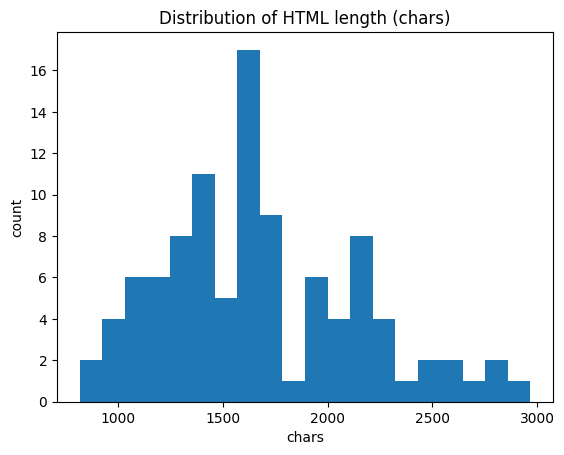

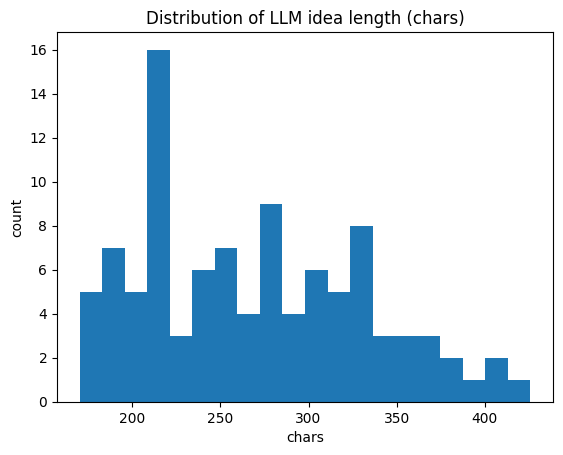

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df["html_len"], bins=20)
plt.title("Distribution of HTML length (chars)")
plt.xlabel("chars")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(df["idea_len"], bins=20)
plt.title("Distribution of LLM idea length (chars)")
plt.xlabel("chars")
plt.ylabel("count")
plt.show()
